In [1]:
## install
# !pip install xgboost

In [2]:
## import
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.decomposition import PCA
import torch
import torch.nn as nn

In [3]:
## variables
seed = 42
ratio_test = 0.2
n_sample_imr, exp_name = 1000, 'exp4'
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
## class
class SiameseNetwork(torch.nn.Module):
    def __init__(self, len_embedding, abstract_len_embedding):
        super(SiameseNetwork, self).__init__()
        self.loss = nn.L1Loss(reduction="mean") 
        self.len_embedding = len_embedding
        self.abstract_len_embedding = abstract_len_embedding  
        self.nn_reg = nn.Sequential(
            ## 1024 to 512
            nn.Linear(self.len_embedding, int(self.len_embedding//2)),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(int(self.len_embedding//2)), 
            ## 256 to 256
            nn.Linear(int(self.len_embedding//2), int(self.len_embedding//4)),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(int(self.len_embedding//4)),
            ## 256 to 128
            nn.Linear(int(self.len_embedding//4), self.abstract_len_embedding),
        )
        self.nn_final_reg = nn.Sequential(
            ##  (128+128) to 1
            nn.Linear(self.abstract_len_embedding * 2, 1),
        )

    def forward_reg(self, x):
        output = self.nn_reg(x)
        return output

    def forward_final_reg(self, x):
        output = self.nn_final_reg(x)
        return output

    def forward(self, fp1, fp2):
        a = self.forward_reg(fp1)
        b = self.forward_reg(fp2)
        x = torch.cat([a, b], dim=1)  # hstack
        output = self.forward_final_reg(x)
        return output

In [5]:
## function

def get_secondary_env(env):
    x_e, y_e = env[0], env[1]
    print(x_e.shape, y_e.shape)
    list_secondary_feature, list_secondary_target = [], []
    for i in range(x_e.shape[0]):
        for j in range(x_e.shape[0]):
            if i != j:
                sf = np.hstack((x_e[i], x_e[j]))
                st = y_e[i] - y_e[j]
                list_secondary_feature.append(sf)
                list_secondary_target.append(st)
    array_secondary_feature = np.array(list_secondary_feature, dtype='float32')
    array_secondary_target = np.array(list_secondary_target, dtype='float32').reshape((-1, 1))
    senv = torch.from_numpy(array_secondary_feature), torch.from_numpy(array_secondary_target)
    print(senv[0].shape, senv[1].shape)
    return senv


def get_model_siamese(senvironments, len_embedding, abstract_len_embedding, batch_size=10000):

    _lr, num_iterations = 1e-3, 1000
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    model_siamese = SiameseNetwork(len_embedding, abstract_len_embedding).to(device)
    optimizer_siamese = torch.optim.Adam(model_siamese.parameters(), lr=_lr)

    for epoch in range(num_iterations):
        
        epoch_loss = 0.0
        for x, y in senvironments:
            p = torch.randperm(len(x))
            x, y = x[p], y[p]
            
            for i in range(0, len(x), batch_size):
                batch_x = x[i:i+batch_size].to(device)
                batch_y = y[i:i+batch_size].to(device)
                ##
                fp1 = batch_x[:, list(range(0, len_embedding, 1))]
                fp2 = batch_x[:, list(range(len_embedding, 2 * len_embedding, 1))]
                ##
                y_pred_siamese = model_siamese(fp1, fp2)
                batch_loss = model_siamese.loss(y_pred_siamese, batch_y)
                ##
                optimizer_siamese.zero_grad()  # Clear buffer
                batch_loss.backward()  # Calculate gradient for all params
                optimizer_siamese.step()  # Update parameters
                ## 
                epoch_loss += float(batch_loss.item())
                
        if epoch % (int(num_iterations // 10)) == 0:
            with open('v2_script_10/logger_' + exp_name + '.log', 'a+') as file1:
                file1.writelines(f'epoch: {epoch}, total_loss: {epoch_loss:.6f}\n\n')

    return model_siamese


In [6]:
## check for word ('cathub/ocp', 'nre/energy', 'original/pca')
## common (dimenet++, Two-Functional-Model, xgboost) 
## (cathub/ocp x org/pca/imr x MAE/r2) 

In [7]:
## 5. cathub, imr, (MAE, r2)
## 6. ocp, imr, (MAE, r2)

In [8]:
df1 = pd.read_pickle(f'datasets/df_cathub_dpp_combined.pickle')
X1 = df1.iloc[:, :-1].values
y1 = df1['nre'].values
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=ratio_test, random_state=seed)
df2 = pd.read_pickle(f'datasets/df_ocp_dpp_combined.pickle')
X2 = df2.iloc[:, :-1].values
y2 = df2['energy'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=ratio_test, random_state=seed)
print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

(8750, 1024) (2188, 1024) (8750,) (2188,)
(263890, 1024) (65973, 1024) (263890,) (65973,)


In [9]:
## choose 'n' samples from cathub
## turn to 'n(n-1)' secondary by '2d'
idx1 = np.random.choice(X_train1.shape[0], n_sample_imr, replace=False)
X_train1_sampled = X_train1[idx1]
y_train1_sampled = y_train1[idx1]
env1 = (X_train1_sampled, y_train1_sampled)
senv1 = get_secondary_env(env1)
## choose 'n' samples from ocp
## turn to 'n(n-1)' secondary by '2d'
idx2 = np.random.choice(X_train2.shape[0], n_sample_imr, replace=False)
X_train2_sampled = X_train2[idx2]
y_train2_sampled = y_train2[idx2]
env2 = (X_train2_sampled, y_train2_sampled)
senv2 = get_secondary_env(env2)
## build a SiameseIMR to transform 'd' to 'pca(d)',
## use that 'SiameseIMR transformation' instead of pca
senvironments = [senv1, senv2]
pca_components = int(int(X_train1.shape[1])//8)
len_embedding, abstract_len_embedding = int(senvironments[0][0].shape[1])//2, pca_components    
model_siamese = get_model_siamese(
    senvironments, 
    len_embedding, 
    abstract_len_embedding,    
)
## save the model
model_path = 'v2_script_10/model_siamese_' + exp_name + '.pt'
torch.save(model_siamese.state_dict(), model_path)

(1000, 1024) (1000,)
torch.Size([999000, 2048]) torch.Size([999000, 1])
(1000, 1024) (1000,)
torch.Size([999000, 2048]) torch.Size([999000, 1])


In [10]:
# load the model
model_siamese = SiameseNetwork(len_embedding, abstract_len_embedding)
model_siamese.load_state_dict(torch.load(model_path))
model_siamese.eval()

SiameseNetwork(
  (loss): L1Loss()
  (nn_reg): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=128, bias=True)
  )
  (nn_final_reg): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

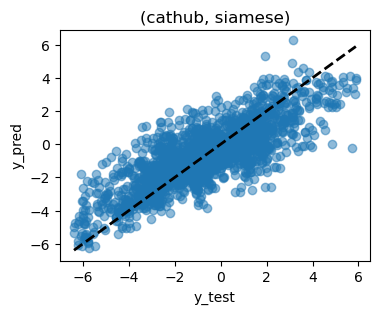

X_train shape: (8750, 1024), X_test shape: (2188, 1024)
y_train shape: (8750,), y_test shape: (2188,)
train to test ratio: 0.8:0.2
Mean Abs. Error: 0.96
R2-score: 0.64


In [11]:
X_train_siamese1 = model_siamese.forward_reg(torch.from_numpy(X_train1).float()).detach().numpy() 
X_test_siamese1 = model_siamese.forward_reg(torch.from_numpy(X_test1).float()).detach().numpy()

lr = 0.2
depth = 8
n_est = 500
model1 = xgb.XGBRegressor(learning_rate=lr, max_depth=depth, n_estimators=n_est)
model1.fit(X_train_siamese1, y_train1)

y_pred1 = model1.predict(X_test_siamese1)
mae1 = mean_absolute_error(y_test1, y_pred1)
r2score1 = r2_score(y_test1, y_pred1)

plt.figure(figsize=(4, 3))
plt.scatter(y_test1, y_pred1, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title(f'(cathub, siamese)')
plt.plot([y_test1.min(), y_test1.max()], [y_test1.min(), y_test1.max()], 'k--', lw=2)
plt.show()
print(f'X_train shape: {X_train1.shape}, X_test shape: {X_test1.shape}')
print(f'y_train shape: {y_train1.shape}, y_test shape: {y_test1.shape}')
print(f'train to test ratio: {1-ratio_test}:{ratio_test}')
print(f'Mean Abs. Error: {mae1:.2f}')
print(f'R2-score: {r2score1:.2f}')

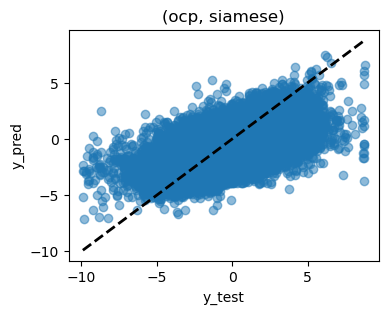

X_train shape: (263890, 1024), X_test shape: (65973, 1024)
y_train shape: (263890,), y_test shape: (65973,)
train to test ratio: 0.8:0.2
Mean Abs. Error: 1.13
R2-score: 0.46


In [12]:
X_train_siamese2 = model_siamese.forward_reg(torch.from_numpy(X_train2).float()).detach().numpy() 
X_test_siamese2 = model_siamese.forward_reg(torch.from_numpy(X_test2).float()).detach().numpy()

lr = 0.2
depth = 8
n_est = 500
model2 = xgb.XGBRegressor(learning_rate=lr, max_depth=depth, n_estimators=n_est)
model2.fit(X_train_siamese2, y_train2)

y_pred2 = model2.predict(X_test_siamese2)
mae2 = mean_absolute_error(y_test2, y_pred2)
r2score2 = r2_score(y_test2, y_pred2)

plt.figure(figsize=(4, 3))
plt.scatter(y_test2, y_pred2, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title(f'(ocp, siamese)')
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.show()
print(f'X_train shape: {X_train2.shape}, X_test shape: {X_test2.shape}')
print(f'y_train shape: {y_train2.shape}, y_test shape: {y_test2.shape}')
print(f'train to test ratio: {1-ratio_test}:{ratio_test}')
print(f'Mean Abs. Error: {mae2:.2f}')
print(f'R2-score: {r2score2:.2f}')